In [2]:
# Import modules
import sys
sys.path.append(r"c:/Users/Raees/Desktop/stuff/NuOscProbExact/src")


from oscprob2nu import *
from globaldefs import *
from hamiltonians2nu import *
from hamiltonians3nu import *
from oscprob3nu import *

import numpy as np 
import matplotlib.pyplot as plt
import math
from scipy.stats import truncnorm
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.integrate import simpson, quad
from scipy.interpolate import interp1d
import copy as cp
import builtins
import itertools
import scipy.linalg as la
from scipy.linalg import expm
import cmath
import sympy as sp
from scipy.stats import norm

In [3]:
# Gaussian fit
def gaus(data, amplitude, mean, sigma):
    return amplitude * math.e**((-0.5 * (data - mean)**2) / sigma**2)

def fluctuated_fit(gaus, bin_centers, counts):
    popt, _ = curve_fit(gaus, bin_centers, counts)
    return popt

def param_values2(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0210, 0.0011),  # ± 0.0011
        'Dm2_32': (2.41e-3, 0.07e-3),  # ± 0.07e-3
        's2th23': (0.57, 0.03, 0.04),  # +0.03, -0.04
        'd_cp': (0.82 * np.pi, 0.27 * np.pi, 0.87 * np.pi)  # +0.27π, -0.87π
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    elif len(params[param]) == 3:
        pos_unc = params[param][1]
        neg_unc = params[param][2]

        if param in ['s2th23']:
            return np.sqrt(central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc))
        else:
            return central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc)

    return central
param_values2('Dm2_32', 0.5)

0.0024449999999999997

In [4]:
# Parameters
bin_centers = np.array([0.375, 0.875, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.125, 2.375, 2.6375, 2.8875, 3.25, 3.75, 4.5])
bin_edges = np.array([0, 0.75, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.25, 2.5, 2.775, 3, 3.5, 4, 5])

# Event counts for muon neutrino beam, muon-to-muon
counts_nd = np.array([5, 42, 72, 96, 120, 148, 170, 192, 208, 214, 212, 204, 170, 112, 66, 36, 16, 5, 1])
counts_fd = np.array([0, 3, 1, 3, 1, 2, 2, 4, 6, 9, 15, 12, 15.8, 10, 7, 9, 3.2, 2.8, 1.8])
adjusted_counts_fd = np.array([ 0.  ,  7.5 ,  1.  ,  3.  ,  1.  ,  2.  ,  2.  ,  4.  ,  6.  ,
        9.  , 15.  , 12.  , 39.5 , 25.  , 19.25, 20.25, 16.  , 14.  ,
       18.  ])
adjusted_counts_nd = np.array([ 37500., 105000.,  72000.,  96000., 120000., 148000., 170000.,
       192000., 208000., 214000., 212000., 204000., 425000., 280000.,
       181500.,  81000.,  80000.,  25000.,  10000.])

# Event counts for electron neutrio beam, muon-to-electron
counts_nd_e = np.array([0.01, 0.5, 2.4, 4.6, 4, 2.6, 1.8 ,1.4, 1.2])
adjusted_counts_nd_e = np.array([10, 500, 2400, 4600, 400, 2600, 1800, 1400, 1200])
counts_fd_e = np.array([5 ,21, 18, 4, 1, 1])
bin_centers_e = np.array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25])
bin_edges_e = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

length_nd = 1 # [km]
length_fd = 810 # [km]

bin_widths = bin_edges[1:] - bin_edges[:-1]

# Event counts for antineutrino beam
anti_counts_nd = np.array([2.5, 20, 38.75, 45 ,67.5, 70, 85, 97.5, 107.5, 113.75, 115, 111.25, 95, 62.5, 37.5, 20, 10, 2.5, 0])
anti_counts_fd = np.array([0.25, 2, 1, 2, 0, 2, 3, 0, 0, 8, 3, 7, 4.4, 6, 2.4, 2, 2.4, 1.25, 1.75])
anti_counts_nd_e = np.array([0, 0.25, 1.3, 2.5, 2.52, 1.9, 1.35, 1.15, 0.95]) # The High CNN one, cause it might be better?
anti_counts_fd_e = np.array([1, 8, 5, 3, 1, 1])

adjusted_anti_counts_nd_e = np.array([0, 250, 1300, 2500, 2520, 1900, 1350, 1150, 950])
adjusted_anti_counts_nd = anti_counts_nd * (bin_widths / 0.1) * 1000
adjusted_anti_counts_fd = anti_counts_fd * (bin_widths / 0.1)

initial_guess = [140, 2, 0.5]

popt_nd, _ = curve_fit(gaus, bin_centers, counts_nd, p0=initial_guess)
print(f"Fitted parameters for observed the unoscillated ND events: Amplitude = {popt_nd[0]}, Mean = {popt_nd[1]}, Sigma = {popt_nd[2]}")


popt_nd_e, _ = curve_fit(gaus, bin_centers_e, counts_nd_e, p0=[5,2, 0.5])
print(f"Fitted parameters for observed the unoscillated ND electon events: Amplitude = {popt_nd_e[0]}, Mean = {popt_nd_e[1]}, Sigma = {popt_nd_e[2]}")

popt_anti_nd, _ = curve_fit(gaus, bin_centers, anti_counts_nd, p0=[120,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = {popt_anti_nd[0]}, Mean = {popt_anti_nd[1]}, Sigma = {popt_anti_nd[2]}")


popt_anti_nd_e, _ = curve_fit(gaus, bin_centers_e, anti_counts_nd_e, p0=[5,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = {popt_anti_nd_e[0]}, Mean = {popt_anti_nd_e[1]}, Sigma = {popt_anti_nd_e[2]}")

x = np.arange(0.01,5,0.01)

Fitted parameters for observed the unoscillated ND events: Amplitude = 212.76692701207105, Mean = 1.8044188236034169, Sigma = 0.525448417032163
Fitted parameters for observed the unoscillated ND electon events: Amplitude = 4.218662147714044, Mean = 2.1341687610051183, Sigma = 0.8475810459857663
Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = 113.1060196955553, Mean = 1.8355298839724858, Sigma = 0.5285564990530245
Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = 2.4344413635605364, Mean = 2.356842604598921, Sigma = 0.9997075655274238


In [9]:
print(np.sum(counts_fd))
print(np.sum(adjusted_counts_fd))

107.6
214.5


In [5]:
x = np.arange(0.01, 5, 0.01)
def osc_prob_3nu(type, case, length, transition, fractions):
    """
    Returns counts, error bars based on 68% confidence interval, Poisson fluctuated counts, probabilities,
    and plots the histogram of counts across different fraction variations.
    """
    # Constants
    energy = x * 1e9
    length_scaled = length * CONV_KM_TO_INV_EV
    length_scaled_nd = 1 * CONV_KM_TO_INV_EV
    length_scaled_fd = 810 * CONV_KM_TO_INV_EV
    
    # Mapping of transition types to indices
    transition_map = {'Pee': 0, 'Pem': 1, 'Pet': 2, 'Pme': 3, 'Pmm': 4, 
                      'Pmt': 5, 'Pte': 6, 'Ptm': 7, 'Ptt': 8}
    index = transition_map.get(transition)
    if index is None:
        raise ValueError(f"Invalid transition: {transition}")
    
    # Fixed and varying parameters for calculations
    fixed_params = ['s2th12', 'Dm2_21']
    varying_params = ['s2th23', 's2th13', 'd_cp', 'Dm2_32']
    fixed_param_values = {param: param_values2(param, 0) for param in fixed_params}
    fraction_combinations = list(itertools.product(fractions, repeat=len(varying_params)))
    
    if type == 'neutrino':
        popt = popt_nd
        bin_edge = bin_edges
        
    elif type == 'antineutrino':
        popt = popt_anti_nd
        bin_edge = bin_edges
    else:
        raise ValueError(f"Invalid type '{type}'. Must be 'neutrino' or 'antineutrino'.")


    # Dictionary to store counts
    hamiltonians = {}
    counts_dict = {}
    size_dict = {}
    iterations = 0
    gaus_x = gaus(x, *popt)
    
    # Loop through each fraction combination
    for fraction_values in fraction_combinations:
        param_values = {param: param_values2(param, frac) for param, frac in zip(varying_params, fraction_values)}
        full_param_values = {**fixed_param_values, **param_values}
        
        hamiltonians[fraction_values] = hamiltonian_3nu_vacuum_energy_independent(
        full_param_values['s2th12'],
        full_param_values['s2th23'],
        full_param_values['s2th13'],
        full_param_values['d_cp'],
        full_param_values['Dm2_21'],
        full_param_values['Dm2_32']
    )

        # Adjust Hamiltonian based on case
        if case == 'vacuum':
            def calculate_hamiltonian(h, e): return h / e
        elif case == 'matter':
            def calculate_hamiltonian(h, e): return hamiltonian_3nu_matter(h, e, VCC_EARTH_CRUST)
        else:
            raise ValueError('Invalid case')
        
        # Oscillation probability calculation
        probabilities = np.array([probabilities_3nu(calculate_hamiltonian(hamiltonians[fraction_values], e),
                                           length_scaled)[index] for e in energy])
        osc_prob = probabilities * gaus_x
        gaussian_func = interp1d(x, osc_prob, fill_value=0, bounds_error=False)
        
        prob_mm_nd = np.array([probabilities_3nu(calculate_hamiltonian(hamiltonians[fraction_values], e), length_scaled_nd)[4] for e in energy])
        prob_mm_fd = np.array([probabilities_3nu(calculate_hamiltonian(hamiltonians[fraction_values], e), length_scaled_fd)[4] for e in energy])

        gaus_mm_nd, gaus_mm_fd = prob_mm_nd * gaus_x, prob_mm_fd * gaus_x

        # Calculate areas under the curve for probability distribution
        areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
        bin_widths = np.diff(bin_edge)
        areas = np.array(areas)

        # Scaling factors based on detector type and index
        scaling_factors = {
            ('antineutrino', None): (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * (np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))),
            ('neutrino', None): (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd)),
        }

        # Determines counts
        if length == 810:
            factor = scaling_factors.get((type, index), scaling_factors.get((type, None), 1))
            counts = (areas / bin_widths) * factor

        elif length == 1:
            counts = areas / bin_widths
        else:
            raise ValueError('Invalid Length')
        counts_dict[fraction_values] = counts
        size_dict[fraction_values] = np.sum(counts)
    
    # Find counts at zero fraction
    zero_fraction = tuple(0 for _ in varying_params)
    if zero_fraction not in counts_dict:
        raise KeyError(f'Fraction {zero_fraction} not found in counts_dict.')
    
    count_at_zero = counts_dict[zero_fraction]
    highest_fraction = builtins.max(size_dict, key=size_dict.get)
    lowest_fraction = builtins.min(size_dict, key=size_dict.get)
    upper_counts = counts_dict[highest_fraction]
    lower_counts = counts_dict[lowest_fraction]
    highest_count = size_dict[highest_fraction]
    lowest_count = size_dict[lowest_fraction]

    print(f"Highest count: {highest_count} at fraction: {highest_fraction}")
    print(f"Corresponding parameters: {[f'{param}={param_values2(param, frac)}' for param, frac in zip(varying_params, highest_fraction)]}")
    print(f"Lowest count: {lowest_count} at fraction: {lowest_fraction}")
    print(f"Corresponding parameters: {[f'{param}={param_values2(param, frac)}' for param, frac in zip(varying_params, lowest_fraction)]}")

    # Stack all counts to build a distribution
    all_counts = np.array(list(counts_dict.values()))
    
    # Compute 68% confidence interval
    diff_upper = upper_counts - count_at_zero
    diff_lower = count_at_zero - lower_counts
    upper_bound_68 = (diff_upper * 0.68) + count_at_zero
    lower_bound_68 = -(diff_lower * 0.68) + count_at_zero
    
    upper_array = upper_bound_68 - count_at_zero
    lower_array = count_at_zero - lower_bound_68
    
    sys_err = np.abs([lower_array, upper_array])
    
    # Generate Poisson fluctuated counts
    fluc_counts = np.random.poisson(count_at_zero)
    
    
    # Plot histograms
    plt.figure(figsize=(9, 6))
    for counts in all_counts:
        iterations += 1
        plt.hist(bin_edge[:-1],bin_edge, weights=counts,  histtype='step', color='red', linewidth=0.5)

    plt.hist(bin_edge[:-1], bin_edge, weights=all_counts[0], histtype='step', label=f'Fraction Variation [{iterations} Iterations]', color='red', linewidth=0.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=count_at_zero,  histtype='step', label='True Count', color='blue', linewidth=2)
    plt.hist(bin_edge[:-1],bin_edge, weights=lower_counts,  histtype='step', label='Lower Counts', color='black', linewidth=1.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=upper_counts,  histtype='step', label='Upper Counts', color='black', linewidth=1.5)
    plt.hist(bin_edge[:-1],bin_edge, weights=lower_bound_68,  histtype='step', label=r'68% Lower Counts', color='green', linewidth=1)
    plt.hist(bin_edge[:-1],bin_edge, weights=upper_bound_68,  histtype='step', label=r'68% Upper Counts', color='green', linewidth=1)
    plt.xlabel('Energy (GeV)')
    plt.ylabel('Events')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title(f'Distribution of {transition} {type.capitalize()} Events Across Different Parameters In {case.capitalize()} At {length} km')
    plt.tight_layout()
    plt.show()
    
    return np.array(count_at_zero), sys_err, fluc_counts, np.array(probabilities)

fractions = [-1, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1]
fractions = [0]








In [6]:
#counts, error, fluc_counts, probs = osc_prob_3nu('neutrino', 'vacuum', length_fd, 'Pmm', fractions)

In [7]:
#plt.figure(figsize=(9,6))
#plt.hist(bin_edges[:-1], bin_edges, weights=counts, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
#plt.errorbar(bin_centers, counts, yerr=error, label='ND Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
#title = r'Simulated Three-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _\mu$ Transitions'
#plt.title(title, fontsize=16)
#plt.ylabel(r'Events / 0.1 GeV', fontsize=14)
#plt.xlabel('Energy (GeV)', fontsize=14)
#plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
#plt.grid(True, linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()

1. me nd vc
- Highest count: 0.000573957347056908 at fraction: (1, 1, -1, 1)
- Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
- Lowest count: 0.0002845756217073943 at fraction: (-1, -1, 0.75, -1)
- Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.212278488295563', 'Dm2_32=0.0023399999999999996']

2. me fd vc
- Highest count: 38.27392485124808 at fraction: (-0.25, 1, 1, 1)
Corresponding parameters: ['s2th23=0.7483314773547882', 's2th13=0.14866068747318506', 'd_cp=3.4243359924128742', 'Dm2_32=0.00248']
Lowest count: 21.558314152097353 at fraction: (-1, -1, -0.25, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=1.8928095737878499', 'Dm2_32=0.0023399999999999996']

3. me nd mat
- Highest count: 0.0005739593773655174 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.00028457677413731646 at fraction: (-1, -1, 0.75, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.212278488295563', 'Dm2_32=0.0023399999999999996']

4. me fd mat
- Highest count: 49.643677135686865 at fraction: (-0.25, 1, 1, 1)
Corresponding parameters: ['s2th23=0.7483314773547882', 's2th13=0.14866068747318506', 'd_cp=3.4243359924128742', 'Dm2_32=0.00248']
Lowest count: 28.65847202295058 at fraction: (-1, -1, -0.25, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=1.8928095737878499', 'Dm2_32=0.0023399999999999996']

5. bar me nd vc
- Highest count: 0.0002926663783428291 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.00014510098559963297 at fraction: (-1, -1, 0.75, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.212278488295563', 'Dm2_32=0.0023399999999999996']

6. bar me fd vc
- Highest count: 18.57541322054747 at fraction: (-0.25, 1, 1, 1)
Corresponding parameters: ['s2th23=0.7483314773547882', 's2th13=0.14866068747318506', 'd_cp=3.4243359924128742', 'Dm2_32=0.00248']
Lowest count: 10.376508707908476 at fraction: (-1, -1, -0.25, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=1.8928095737878499', 'Dm2_32=0.0023399999999999996']

7. bar me nd mat
- Highest count: 0.000292667331233153 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.00014510152656348375 at fraction: (-1, -1, 0.75, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.212278488295563', 'Dm2_32=0.0023399999999999996']                        

8. bar me fd mat                           
- Highest count: 24.01414961185779 at fraction: (-0.25, 1, 1, 1)
Corresponding parameters: ['s2th23=0.7483314773547882', 's2th13=0.14866068747318506', 'd_cp=3.4243359924128742', 'Dm2_32=0.00248']
Lowest count: 13.741061107776732 at fraction: (-1, -1, -0.25, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=1.8928095737878499', 'Dm2_32=0.0023399999999999996']

Highest count: 0.0003625287681762846 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 0.0003625287681762846 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


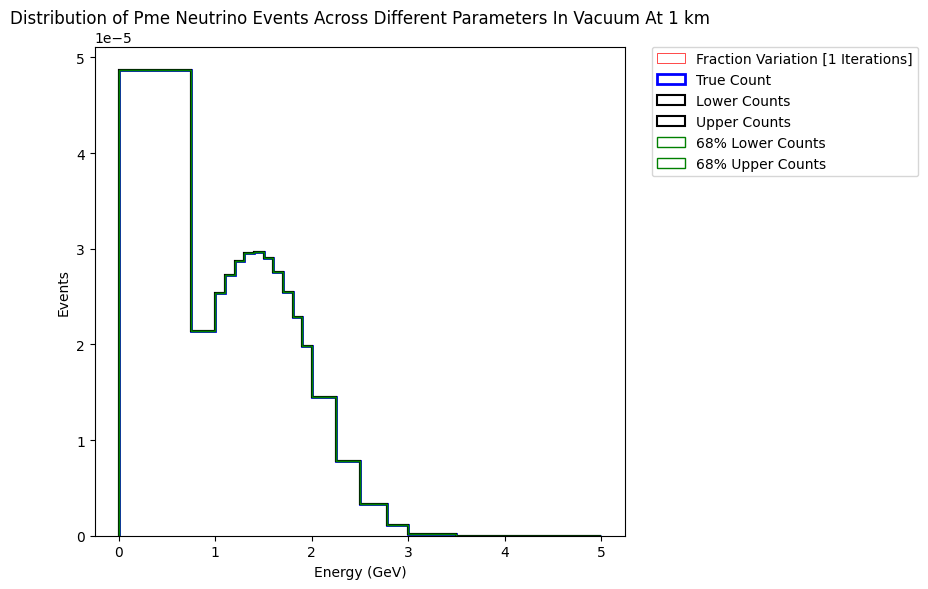

C:\Users\Raees\AppData\Local\Temp\ipykernel_10952\1120201139.py:78: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_10952\1120201139.py:78: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


Highest count: 28.373339359138182 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 28.373339359138182 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


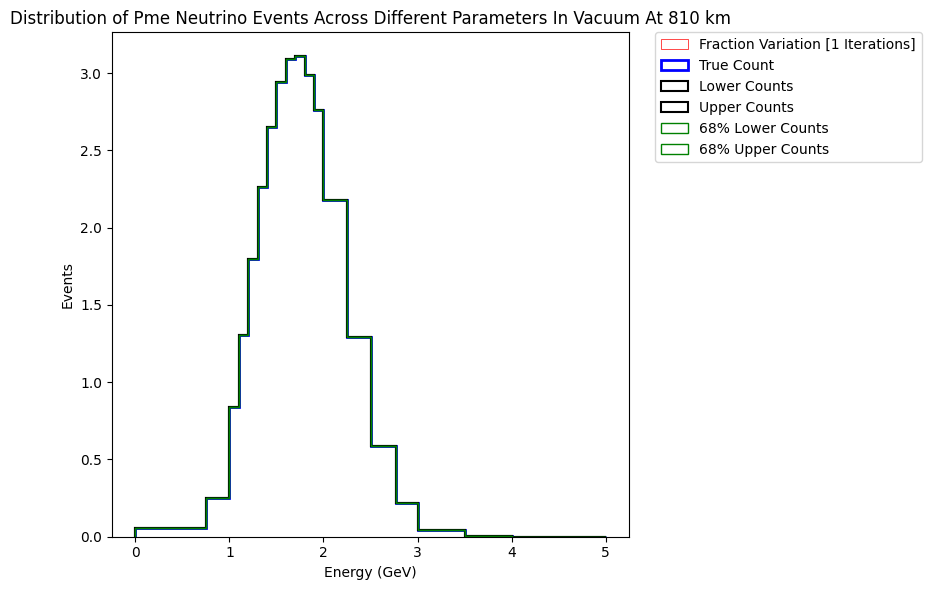

Highest count: 0.00036253021375658596 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 0.00036253021375658596 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


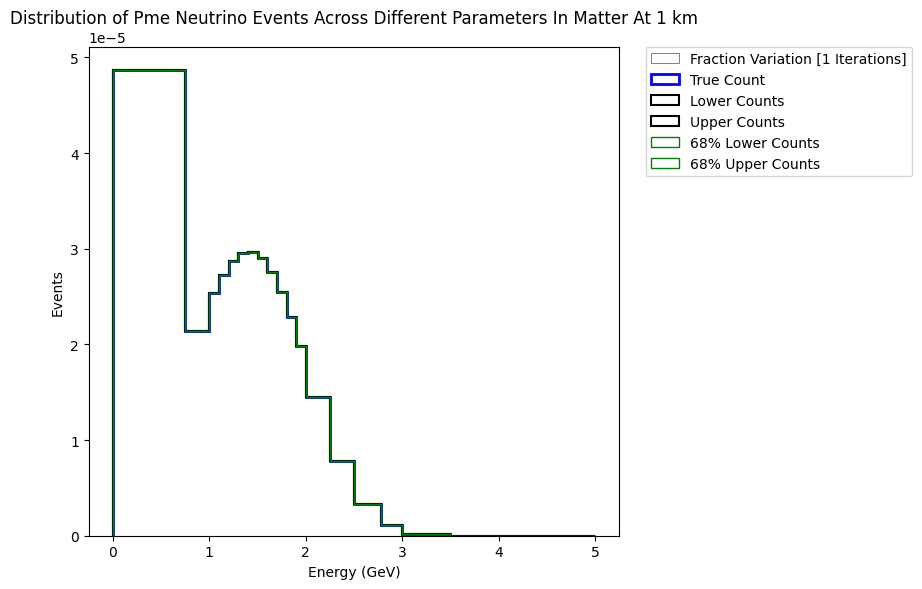

Highest count: 37.515419100960514 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 37.515419100960514 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


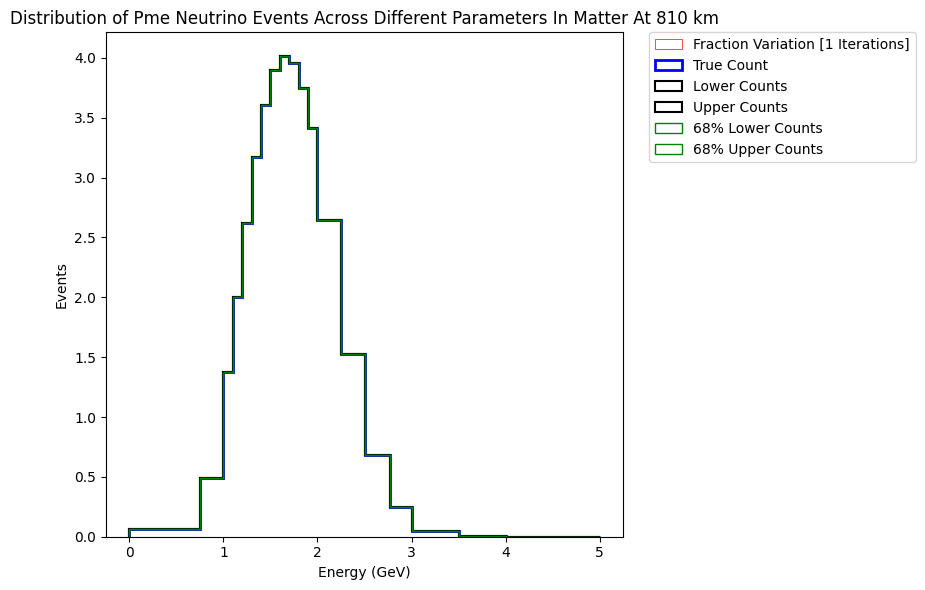

Highest count: 0.00018488634173704046 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 0.00018488634173704046 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


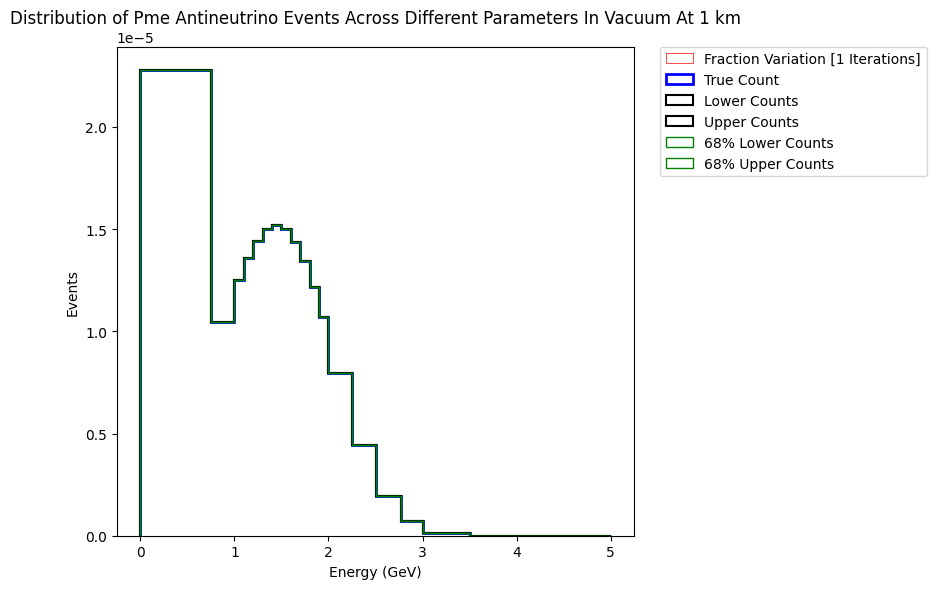

Highest count: 13.701406676870384 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 13.701406676870384 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


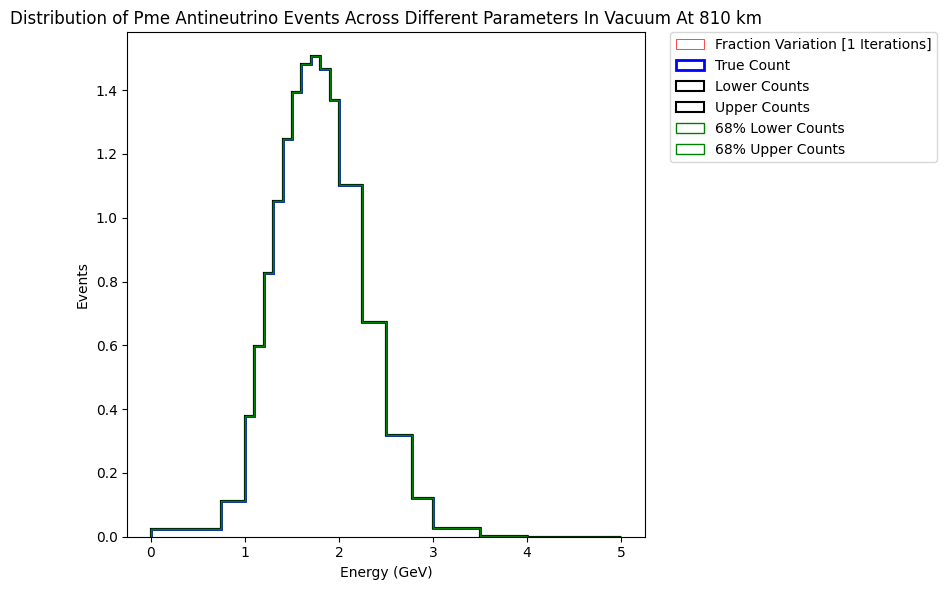

Highest count: 0.00018488702030439568 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 0.00018488702030439568 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


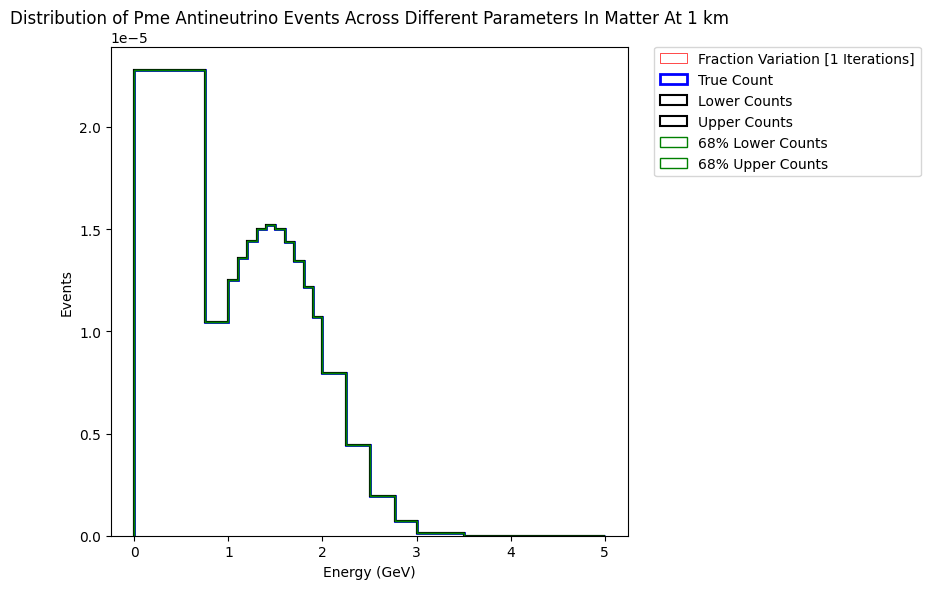

Highest count: 18.050773949800202 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 18.050773949800202 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


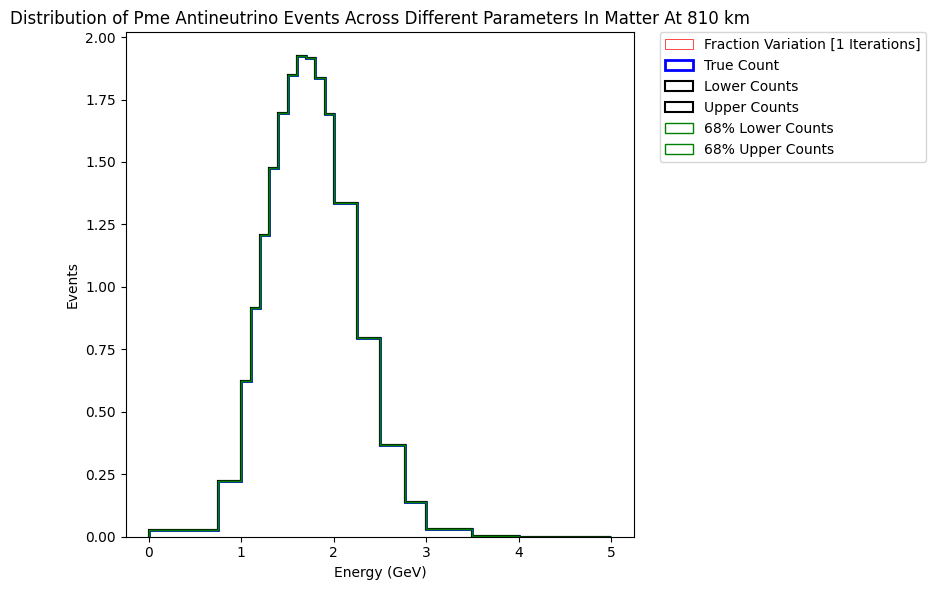

In [8]:
counts1, error1, fluc_counts1, probs1 = osc_prob_3nu('neutrino', 'vacuum', length_nd, 'Pme', fractions)
counts2, error2, fluc_counts2, probs2 = osc_prob_3nu('neutrino', 'vacuum', length_fd, 'Pme', fractions)

counts3, error3, fluc_counts3, probs3 = osc_prob_3nu('neutrino', 'matter', length_nd, 'Pme', fractions)
counts4, error4, fluc_counts4, probs4 = osc_prob_3nu('neutrino', 'matter', length_fd, 'Pme', fractions)


counts1_, error1_, fluc_counts1_, probs1_ = osc_prob_3nu('antineutrino', 'vacuum', length_nd, 'Pme', fractions)
counts2_, error2_, fluc_counts2_, probs2_ = osc_prob_3nu('antineutrino', 'vacuum', length_fd, 'Pme', fractions)

counts3_, error3_, fluc_counts3_, probs3_ = osc_prob_3nu('antineutrino', 'matter', length_nd, 'Pme', fractions)
counts4_, error4_, fluc_counts4_, probs4_ = osc_prob_3nu('antineutrino', 'matter', length_fd, 'Pme', fractions)

- Highest count: 0.000573957347056908 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.0002848106062942922 at fraction: (-1, -1, 0.5, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.0002209841782523', 'Dm2_32=0.0023399999999999996']


- Highest count: 3.526778314163048e-06 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 1.8285318471986933e-06 at fraction: (-1, -1, 0.5, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.0002209841782523', 'Dm2_32=0.0023399999999999996']

- Highest count: 0.0005739593773655174 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.00028481175397420137 at fraction: (-1, -1, 0.5, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.0002209841782523', 'Dm2_32=0.0023399999999999996']

- Highest count: 3.617990168073419e-06 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 1.848846488760708e-06 at fraction: (-1, -1, 0.5, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.0002209841782523', 'Dm2_32=0.0023399999999999996']

- Highest count: 0.0002926663783428291 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.00014523248074860542 at fraction: (-1, -1, 0.5, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.0002209841782523', 'Dm2_32=0.0023399999999999996']

- Highest count: 8.115932362788544e-07 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 4.2148230601870936e-07 at fraction: (-1, -1, 0.5, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.0002209841782523', 'Dm2_32=0.0023399999999999996']

- Highest count: 0.000292667331233153 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 0.0001452330195052757 at fraction: (-1, -1, 0.5, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.0002209841782523', 'Dm2_32=0.0023399999999999996']

- Highest count: 8.326338582941046e-07 at fraction: (1, 1, -1, 1)
Corresponding parameters: ['s2th23=0.7745966692414834', 's2th13=0.14866068747318506', 'd_cp=-0.1570796326794901', 'Dm2_32=0.00248']
Lowest count: 4.2657509586836885e-07 at fraction: (-1, -1, 0.5, -1)
Corresponding parameters: ['s2th23=0.7280109889280517', 's2th13=0.14106735979665885', 'd_cp=3.0002209841782523', 'Dm2_32=0.0023399999999999996']

In [8]:

counts1 = [4.86963864e-05, 2.14428672e-05, 2.53702609e-05, 2.72907241e-05,
 2.87467755e-05, 2.95825036e-05, 2.96864252e-05, 2.90083431e-05,
 2.75685674e-05, 2.54569943e-05, 2.28216985e-05, 1.98490115e-05,
 1.44690531e-05, 7.81695116e-06, 3.31945743e-06, 1.16730070e-06,
 2.25742871e-07, 9.61545212e-09, 8.98012635e-11]
error1 = [[6.71442215e-06, 3.16119124e-06, 3.74115246e-06, 4.02479996e-06,
  4.23993623e-06, 4.36355025e-06, 4.37918217e-06, 4.27941300e-06,
  4.06722756e-06, 3.75588048e-06, 3.36721437e-06, 2.92872089e-06,
  2.13502316e-06, 1.15353017e-06, 4.89872351e-07, 1.72273547e-07,
  3.33171430e-08, 1.41921502e-09, 1.32550134e-11],
 [1.99192322e-05, 8.46618846e-06, 1.00148107e-05, 1.07719667e-05,
  1.13458559e-05, 1.16749744e-05, 1.17153572e-05, 1.14472241e-05,
  1.08786137e-05, 1.00450156e-05, 9.00486696e-06, 7.83169047e-06,
  5.70871701e-06, 3.08399110e-06, 1.30955543e-06, 4.60493913e-07,
  8.90515005e-08, 3.79295376e-09 ,3.54221774e-11]]

counts2 = [5.50532148e-02, 2.50211250e-01, 8.37431354e-01, 1.30406218e+00,
 1.79480787e+00, 2.26006284e+00, 2.65404172e+00, 2.93992874e+00,
 3.09409312e+00, 3.10849245e+00, 2.99072292e+00, 2.76170503e+00,
 2.18141643e+00, 1.29081300e+00, 5.87133122e-01, 2.17480240e-01,
 4.38916883e-02, 1.97306063e-03, 1.91312201e-05]
error2= [[9.77579243e-03, 4.92279666e-02, 1.93372702e-01, 2.85338210e-01,
  3.67753420e-01, 4.33338583e-01, 4.77554090e-01, 4.98413709e-01,
  4.96308539e-01, 4.73697810e-01, 4.34620666e-01, 3.84067301e-01,
  2.84007444e-01, 1.54382917e-01, 6.51999359e-02, 2.26648702e-02,
  4.31332583e-03, 1.78244141e-04, 1.61482298e-06],
 [3.84413994e-02, 1.73429474e-02, 1.69000273e-01, 3.06421621e-01,
  4.47219391e-01, 5.73689637e-01, 6.72783638e-01, 7.36397235e-01,
  7.61367679e-01 ,7.49082220e-01, 7.04661603e-01, 6.35795933e-01,
  4.83146560e-01, 2.70666228e-01, 1.16835281e-01, 4.12616960e-02,
  7.94860584e-03, 3.33141344e-04, 3.04348734e-06]]

count3 = [4.86977074e-05, 2.14428813e-05, 2.53702747e-05, 2.72907376e-05,
 2.87467885e-05, 2.95825159e-05, 2.96864367e-05, 2.90083535e-05,
 2.75685766e-05, 2.54570023e-05, 2.28217053e-05, 1.98490170e-05,
 1.44690568e-05, 7.81695293e-06, 3.31945810e-06, 1.16730091e-06,
 2.25742908e-07, 9.61545345e-09, 8.98012741e-11]
error3 = [[6.71460340e-06, 3.16119328e-06, 3.74115446e-06, 4.02480192e-06,
  4.23993812e-06, 4.36355204e-06, 4.37918384e-06, 4.27941451e-06,
  4.06722890e-06, 3.75588165e-06, 3.36721535e-06, 2.92872169e-06,
  2.13502370e-06, 1.15353043e-06, 4.89872448e-07, 1.72273578e-07,
  3.33171484e-08, 1.41921522e-09, 1.32550149e-11],
 [1.99195976e-05, 8.46619215e-06, 1.00148143e-05, 1.07719702e-05,
  1.13458592e-05, 1.16749776e-05, 1.17153602e-05, 1.14472268e-05,
  1.08786160e-05 ,1.00450177e-05, 9.00486869e-06, 7.83169189e-06,
  5.70871795e-06, 3.08399154e-06 ,1.30955559e-06, 4.60493965e-07,
  8.90515096e-08, 3.79295408e-09, 3.54221799e-11]]

counts4 = [6.33558200e-02, 4.94097895e-01, 1.37807390e+00, 2.00118156e+00,
 2.61821017e+00, 3.17084220e+00, 3.60916688e+00, 3.89651353e+00,
 4.01318654e+00, 3.95808413e+00, 3.74769026e+00, 3.41255832e+00,
 2.64289928e+00, 1.52752772e+00, 6.81673062e-01, 2.48645005e-01,
 4.95069476e-02, 2.18500491e-03, 2.08915890e-05]
error4 = [[1.36663968e-02, 9.19922653e-02, 2.82845251e-01, 3.97441409e-01,
  4.97053100e-01, 5.73564960e-01, 6.22220993e-01, 6.41352905e-01,
  6.32122731e-01, 5.98102668e-01, 5.44648967e-01, 4.78118462e-01,
  3.50250348e-01, 1.88185630e-01, 7.86950709e-02, 2.71283776e-02,
  5.12323775e-03, 2.09361308e-04, 1.87937549e-06],
 [3.84970604e-02, 3.67107136e-02, 2.49141224e-01, 4.19308230e-01,
  5.86061169e-01, 7.30062742e-01, 8.37803699e-01, 9.01617331e-01,
  9.19456797e-01, 8.94288533e-01, 8.33050906e-01, 7.45270368e-01,
  5.59665319e-01, 3.09097385e-01, 1.31875886e-01, 4.61293766e-02,
  8.81056476e-03, 3.64857582e-04, 3.30157312e-06]]

counts1_ = [2.27911283e-05, 1.04557967e-05, 1.25299731e-05, 1.35885361e-05,
 1.44365074e-05, 1.49901635e-05, 1.51848639e-05, 1.49844440e-05,
 1.43873166e-05, 1.34277681e-05, 1.21719176e-05, 1.07089650e-05,
 7.96521563e-06, 4.44275053e-06, 1.95521060e-06, 7.14444878e-07,
 1.44565351e-07, 6.70557944e-09, 6.89813399e-11]
error1_ = [[3.14299760e-06, 1.54143542e-06, 1.84769656e-06, 2.00401951e-06,
  2.12927793e-06, 2.21111561e-06, 2.23998977e-06, 2.21055809e-06,
  2.12258013e-06, 1.98110953e-06, 1.79589864e-06, 1.58010744e-06,
  1.17533075e-06, 6.55606967e-07, 2.88542268e-07, 1.05439812e-07,
  2.13362487e-08, 9.89725816e-10, 1.01819141e-11],
 [9.32091633e-06, 4.12821191e-06, 4.94615728e-06, 5.36355316e-06,
  5.69783987e-06, 5.91598905e-06, 5.99250656e-06, 5.91313614e-06,
  5.67726467e-06, 5.29843130e-06, 4.80273171e-06, 4.22536393e-06,
  3.14264899e-06, 1.75278073e-06, 7.71347838e-07, 2.81844679e-07,
  5.70284154e-08, 2.64511205e-09, 2.72097386e-11]]

counts2_ = [2.39166109e-02, 1.12421929e-01, 3.79967017e-01, 5.96477526e-01,
 8.27957177e-01, 1.05194818e+00, 1.24696025e+00, 1.39488536e+00,
 1.48312225e+00, 1.50598173e+00, 1.46506382e+00, 1.36852294e+00,
 1.10320975e+00, 6.73926531e-01, 3.17681614e-01, 1.22263170e-01,
 2.58233701e-02, 1.26396235e-03, 1.34988455e-05]
error2_ = [[4.32479084e-03, 2.24478339e-02, 8.86672510e-02, 1.32008232e-01,
  1.71784212e-01, 2.04489063e-01, 2.27761192e-01, 2.40350712e-01,
  2.42092563e-01, 2.33817433e-01, 2.17170738e-01, 1.94348742e-01,
  1.46905442e-01, 8.26450884e-02, 3.62555703e-02, 1.31238938e-02,
  2.61846708e-03, 1.18212298e-04, 1.18327169e-06],
 [1.69753434e-02, 8.30602847e-03, 7.85340960e-02, 1.43165411e-01,
  2.10538306e-01, 2.72424040e-01, 3.22491737e-01, 3.56520646e-01,
  3.72495184e-01, 3.70524868e-01, 3.52556103e-01, 3.21897397e-01,
  2.49771235e-01, 1.44587430e-01, 6.47399945e-02, 2.37782729e-02,
  4.79690190e-03, 2.19246965e-04, 2.20915841e-06]]

counts3_ = [2.27917431e-05, 1.04558036e-05, 1.25299800e-05, 1.35885428e-05,
 1.44365139e-05, 1.49901697e-05, 1.51848698e-05, 1.49844494e-05,
 1.43873214e-05, 1.34277723e-05, 1.21719212e-05, 1.07089680e-05,
 7.96521767e-06, 4.44275154e-06, 1.95521099e-06, 7.14445008e-07,
 1.44565375e-07, 6.70558036e-09 ,6.89813480e-11]
error3_ = [[3.14308193e-06 ,1.54143642e-06, 1.84769754e-06, 2.00402048e-06,
  2.12927888e-06, 2.21111651e-06, 2.23999062e-06, 2.21055887e-06,
  2.12258083e-06, 1.98111015e-06 ,1.79589916e-06 ,1.58010788e-06,
  1.17533105e-06, 6.55607113e-07 ,2.88542326e-07, 1.05439830e-07,
  2.13362521e-08, 9.89725950e-10, 1.01819153e-11],
 [9.32108642e-06, 4.12821371e-06, 4.94615906e-06, 5.36355491e-06,
  5.69784156e-06, 5.91599067e-06, 5.99250807e-06, 5.91313752e-06,
  5.67726591e-06, 5.29843239e-06, 4.80273264e-06, 4.22536470e-06,
  3.14264950e-06, 1.75278098e-06, 7.71347936e-07, 2.81844711e-07,
  5.70284212e-08, 2.64511228e-09, 2.72097405e-11]]

counts4_ = [2.75035638e-02, 2.21770406e-01, 6.24949425e-01, 9.14880640e-01,
 1.20720326e+00, 1.47515249e+00, 1.69489206e+00 ,1.84786164e+00,
 1.92276165e+00, 1.91667399e+00, 1.83500839e+00, 1.69024405e+00
, 1.33588867e+00 ,7.97101436e-01, 3.68643595e-01, 1.39714367e-01,
 2.91105972e-02, 1.39899234e-03, 1.47333346e-05]
error4_ = [[6.00838199e-03, 4.18923568e-02 ,1.29814773e-01 ,1.83990431e-01,
  2.32259574e-01, 2.70666805e-01, 2.96676152e-01, 3.09108109e-01,
  3.08085881e-01, 2.94904056e-01, 2.71788597e-01, 2.41564469e-01,
  1.80817799e-01, 1.00496687e-01, 4.36346041e-02, 1.56576287e-02,
  3.09878814e-03, 1.38269378e-04, 1.37075998e-06],
 [1.69799212e-02, 1.74739065e-02, 1.15942554e-01, 1.96158218e-01,
  2.76195758e-01, 3.46989149e-01, 4.01892646e-01, 4.36784198e-01,
  4.50074914e-01, 4.42541101e-01, 4.16939142e-01, 3.77429600e-01,
  2.89370184e-01, 1.65119963e-01, 7.30674405e-02, 2.65788638e-02,
  5.31547462e-03, 2.40020671e-04, 2.39529410e-06]]



print('Counts nu me at fd in vc',np.sum(counts2 * (bin_widths / 0.1)))
print('Counts nu me at fd in mat',np.sum(counts4 * (bin_widths / 0.1)))

print('Counts nu bar me at fd in vc',np.sum(counts2_ * (bin_widths / 0.1)))
print('Counts nu bar me at fd in mat',np.sum(counts4_ * (bin_widths / 0.1)))

Counts nu me at fd in vc 35.797810717351
Counts nu me at fd in mat 46.63470923769
Counts nu bar me at fd in vc 17.508444578455002
Counts nu bar me at fd in mat 22.703628096545998


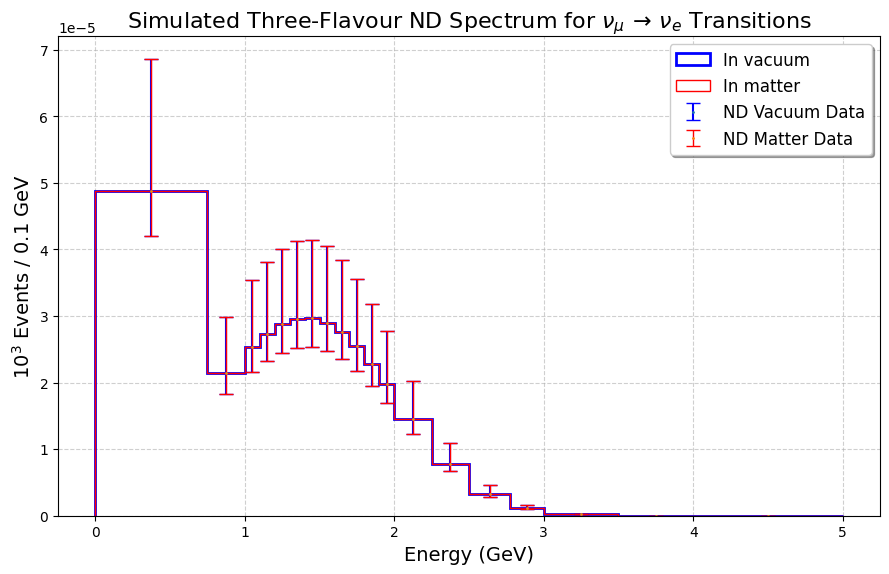

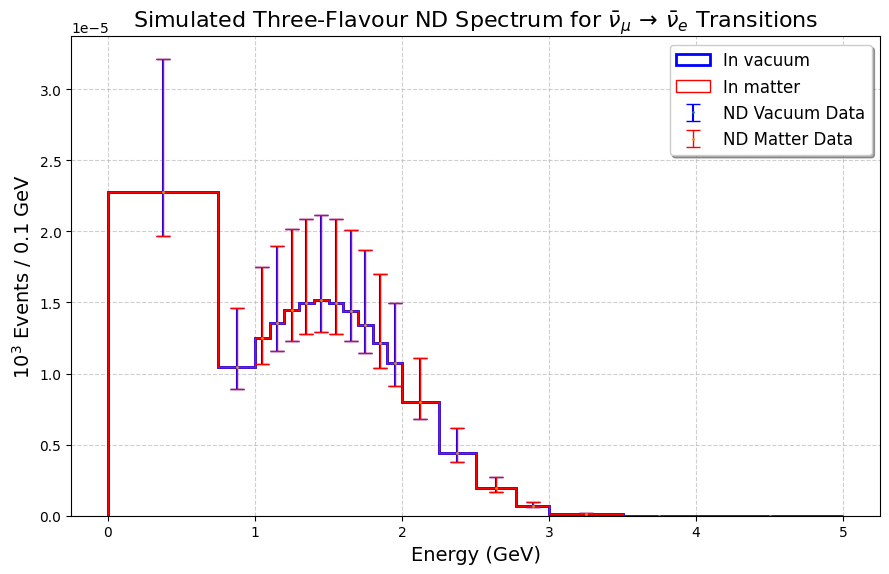

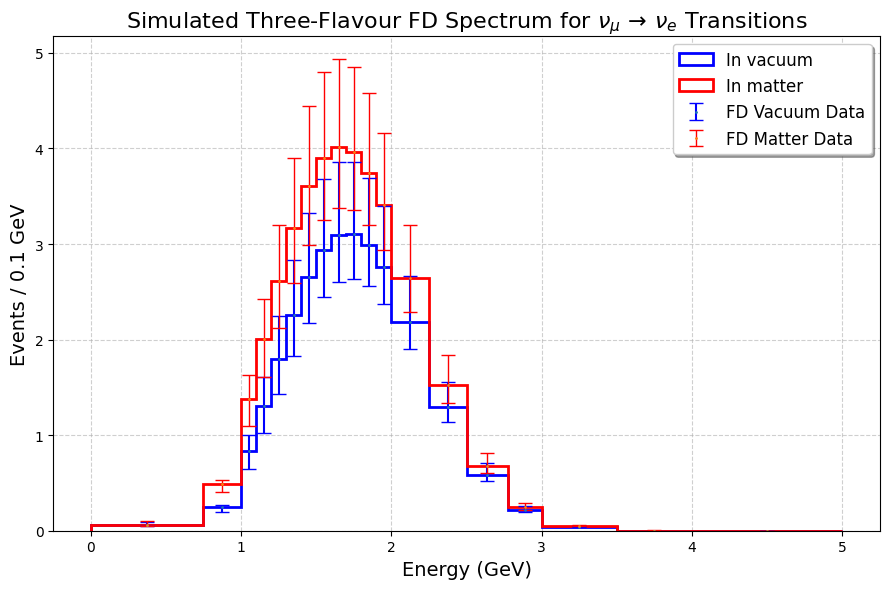

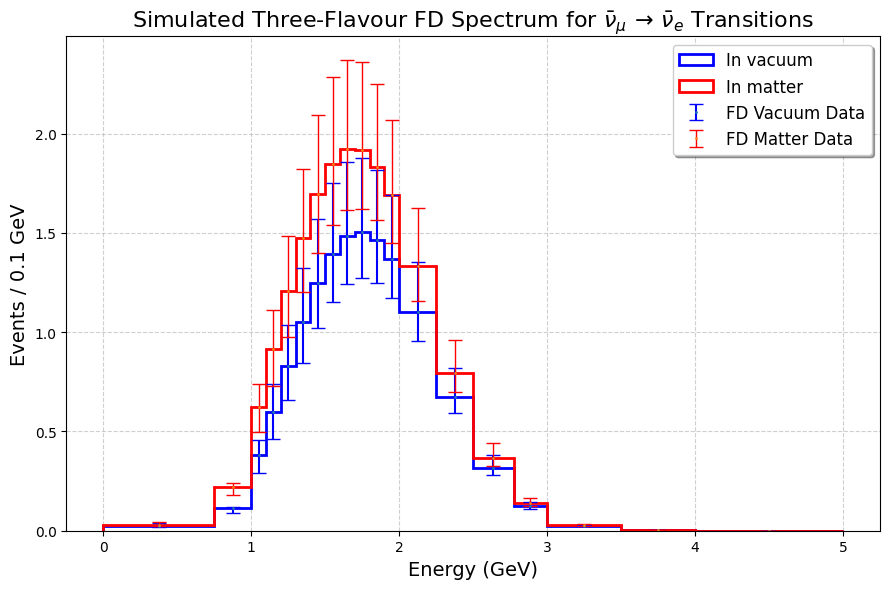

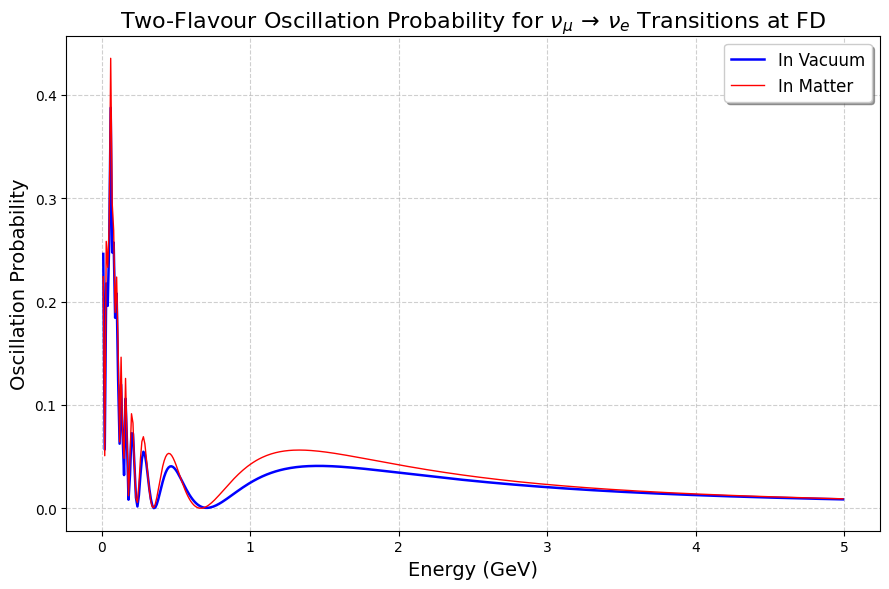

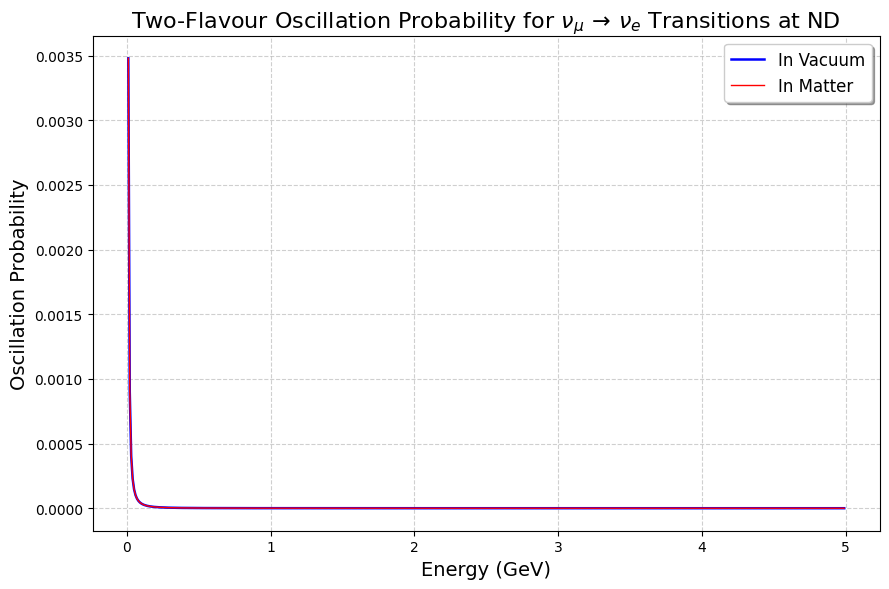

In [11]:
plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts1, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts3, histtype='step', label=r'In matter', linewidth=1, color='red')
plt.errorbar(bin_centers, counts1, yerr=error1, label='ND Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.errorbar(bin_centers, counts3, yerr=error3, label='ND Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour ND Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts1_, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts3_, histtype='step', label=r'In matter', linewidth=1, color='red')
plt.errorbar(bin_centers, counts1_, yerr=error1_, label='ND Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.errorbar(bin_centers, counts3_, yerr=error3_, label='ND Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour ND Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts2, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts4, histtype='step', label=r'In matter', linewidth=2, color='red')
plt.errorbar(bin_centers, counts2, yerr=error2, label='FD Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.errorbar(bin_centers, counts4, yerr=error4, label='FD Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts2_, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts4_, histtype='step', label=r'In matter', linewidth=2, color='red')
plt.errorbar(bin_centers, counts2_, yerr=error2_, label='FD Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
plt.errorbar(bin_centers, counts4_, yerr=error4_, label='FD Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour FD Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Osc prob
plt.figure(figsize=(9,6))
plt.plot(x, probs2, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, probs4, label=r'In Matter', linewidth=1, color='r')
title = r'Two-Flavour Oscillation Probability for $\nu _\mu\, \to\, \nu _e$ Transitions at FD'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, probs1, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, probs3, label=r'In Matter', linewidth=1, color='r')
title = r'Two-Flavour Oscillation Probability for $\nu _\mu\, \to\, \nu _e$ Transitions at ND'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Neutrino Event Counts and Probabilities ---\n")
print(f"Near Detector (Vacuum):       Counts = {counts1}, Error = {error1}, Fluctuated Counts = {fluc_counts1}, Probability = {probs1}")
print(f"Far Detector (Vacuum):        Counts = {counts2}, Error = {error2}, Fluctuated Counts = {fluc_counts2}, Probability = {probs2}")

print(f"Near Detector (Matter):       Counts = {counts3}, Error = {error3}, Fluctuated Counts = {fluc_counts3}, Probability = {probs3}")
print(f"Far Detector (Matter):        Counts = {counts4}, Error = {error4}, Fluctuated Counts = {fluc_counts4}, Probability = {probs4}")

print("\n--- Antineutrino Event Counts and Probabilities ---\n")
print(f"Near Detector (Vacuum):       Counts = {counts1_}, Error = {error1_}, Fluctuated Counts = {fluc_counts1_}, Probability = {probs1_}")
print(f"Far Detector (Vacuum):        Counts = {counts2_}, Error = {error2_}, Fluctuated Counts = {fluc_counts2_}, Probability = {probs2_}")

print(f"Near Detector (Matter):       Counts = {counts3_}, Error = {error3_}, Fluctuated Counts = {fluc_counts3_}, Probability = {probs3_}")
print(f"Far Detector (Matter):        Counts = {counts4_}, Error = {error4_}, Fluctuated Counts = {fluc_counts4_}, Probability = {probs4_}")


--- Neutrino Event Counts and Probabilities ---

Near Detector (Vacuum):       Counts = [4.86963864e-05 2.14428672e-05 2.53702609e-05 2.72907241e-05
 2.87467755e-05 2.95825036e-05 2.96864252e-05 2.90083431e-05
 2.75685674e-05 2.54569943e-05 2.28216985e-05 1.98490115e-05
 1.44690531e-05 7.81695116e-06 3.31945743e-06 1.16730070e-06
 2.25742871e-07 9.61545212e-09 8.98012635e-11], Error = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], Fluctuated Counts = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], Probability = [3.47962882e-03 9.01315417e-04 4.04195864e-04 2.28260706e-04
 1.46408700e-04 1.01814723e-04 7.48746523e-05 5.73661868e-05
 4.53506257e-05 3.67494697e-05 3.03817789e-05 2.55362768e-05
 2.17638223e-05 1.87694841e-05 1.63531093e-05 1.43749922e-05
 1.27352223e-05 1.13608177e-05 1.01974629e-05 9.20406009e-06
 8.34904871e-06 7.60786809e-06 6.96117378e-06 6.39356251e-06
 5.89264649e-06 5.44837180e-06 5.05250996e-06 4.

C:\Users\Raees\AppData\Local\Temp\ipykernel_10952\1120201139.py:78: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


Highest count: 651.9643868660642 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 651.9643868660642 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


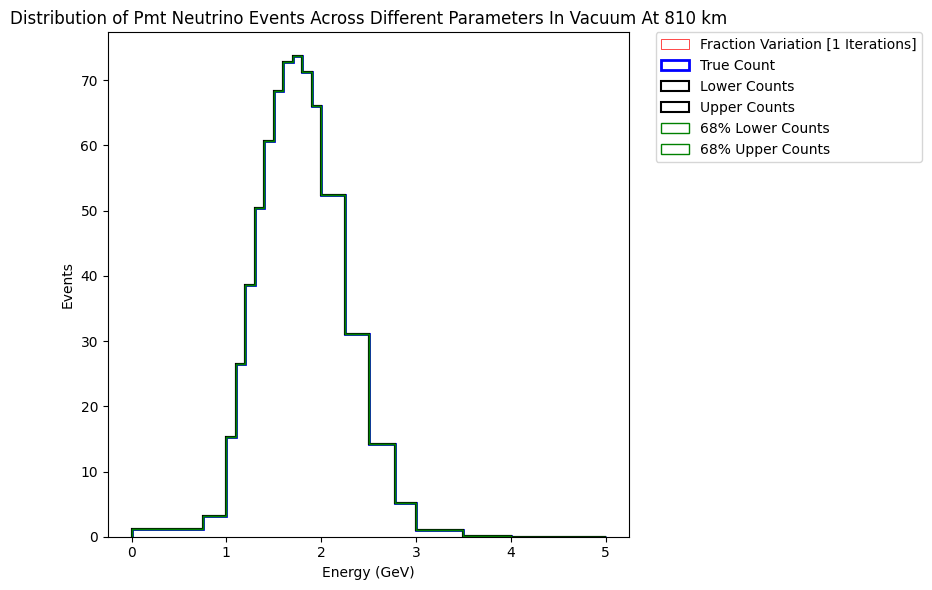

Highest count: 648.7466676050066 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 648.7466676050066 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


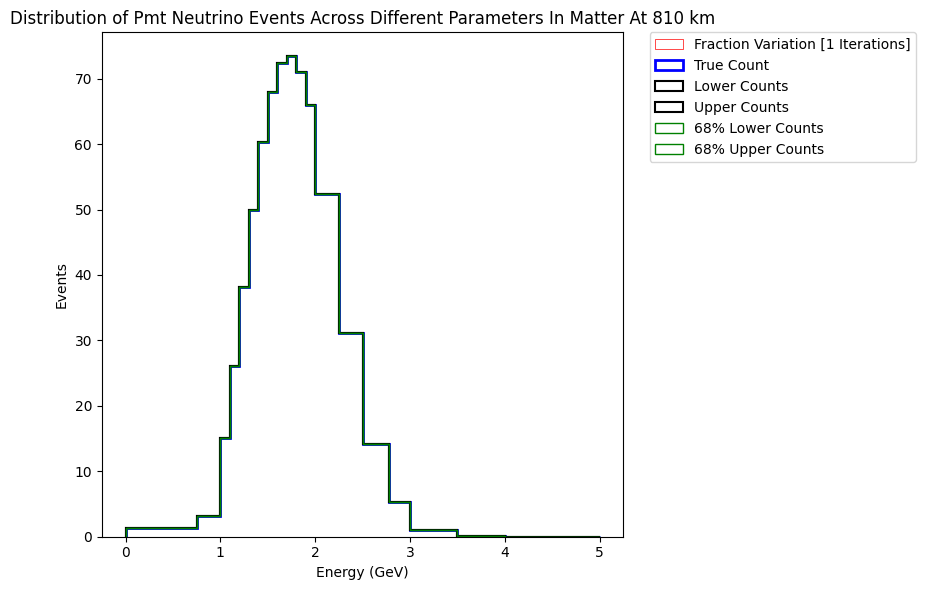

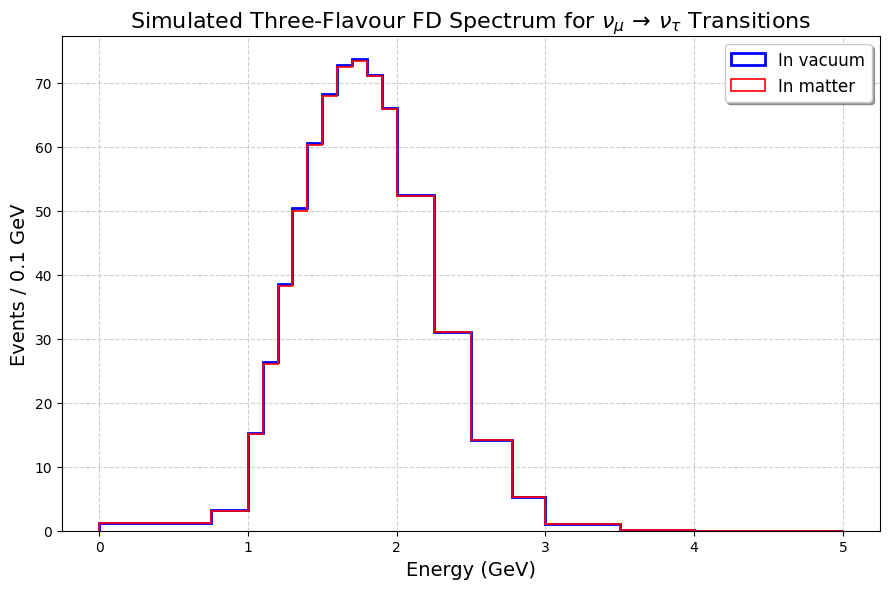

Highest count: 112.76796162648816 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 112.76796162648816 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


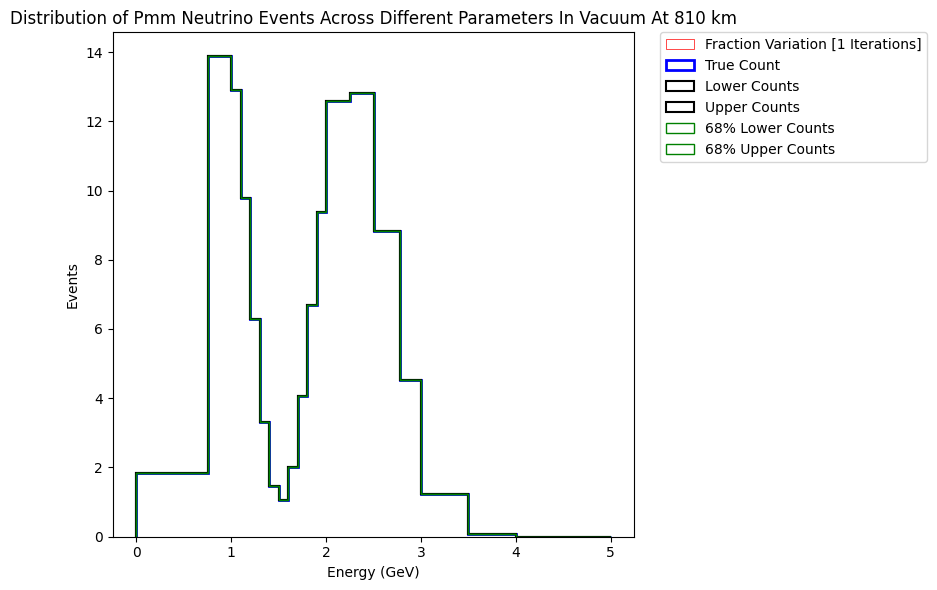

Highest count: 112.3648431162912 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 112.3648431162912 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']


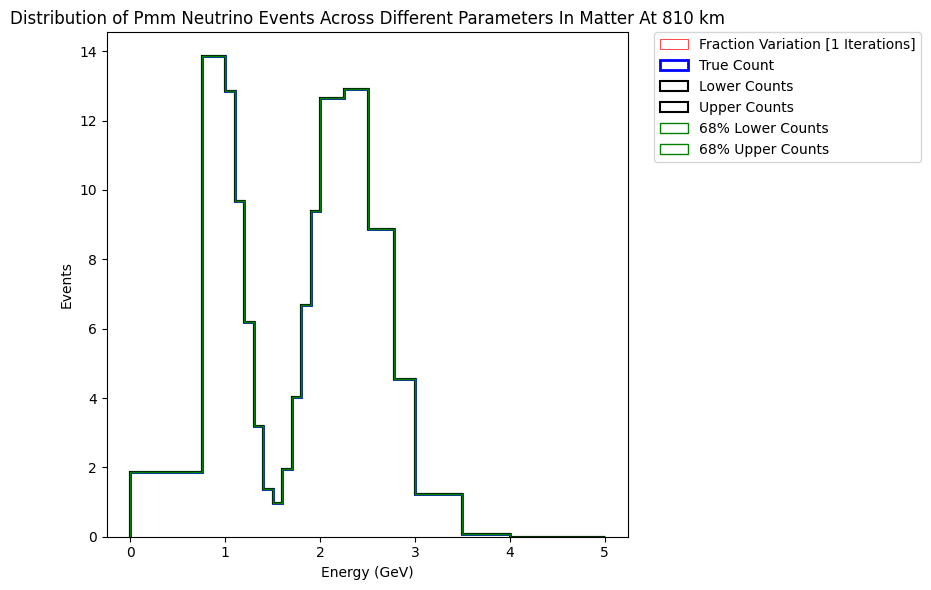

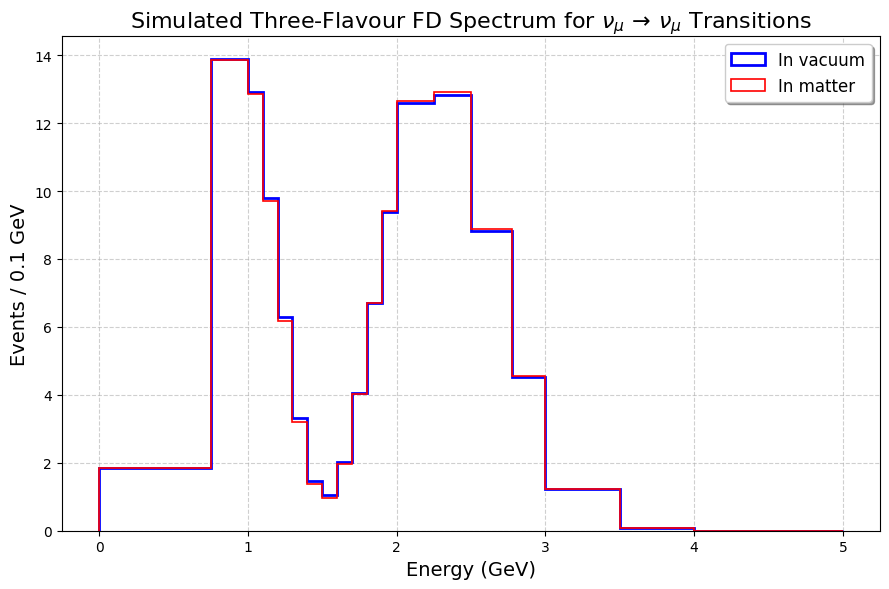

In [ ]:
counts_mt, error_mt, _, _ = osc_prob_3nu('neutrino', 'vacuum', length_fd, 'Pmt', fractions)
counts_mt2, error_mt2, _, _ = osc_prob_3nu('neutrino', 'matter', length_fd, 'Pmt', fractions)


plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts_mt, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_mt2, histtype='step', label=r'In matter', linewidth=1.2, color='red')
#plt.errorbar(bin_centers, counts2, yerr=error2, label='FD Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
#plt.errorbar(bin_centers, counts4, yerr=error4, label='FD Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _\tau$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


counts_mm, error_mm, _, _ = osc_prob_3nu('neutrino', 'vacuum', length_fd, 'Pmm', fractions)
counts_mm2, error_mm2, _, _ = osc_prob_3nu('neutrino', 'matter', length_fd, 'Pmm', fractions)

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts_mm, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_mm2, histtype='step', label=r'In matter', linewidth=1.2, color='red')
#plt.errorbar(bin_centers, counts2, yerr=error2, label='FD Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
#plt.errorbar(bin_centers, counts4, yerr=error4, label='FD Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _\mu$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




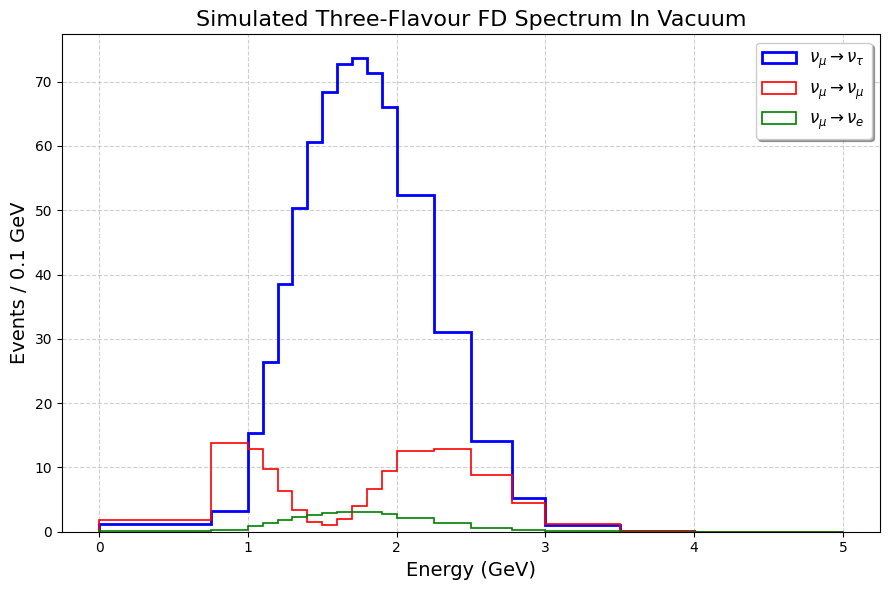

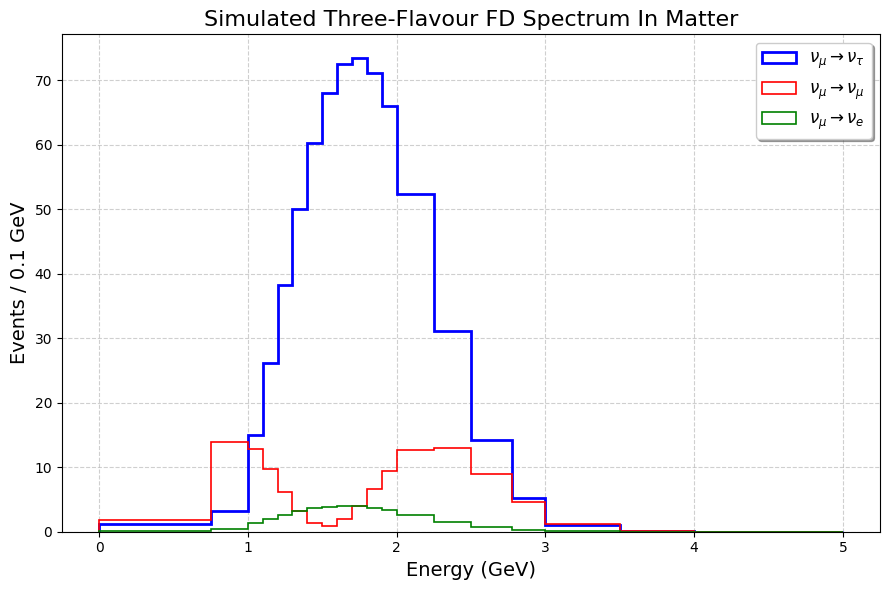

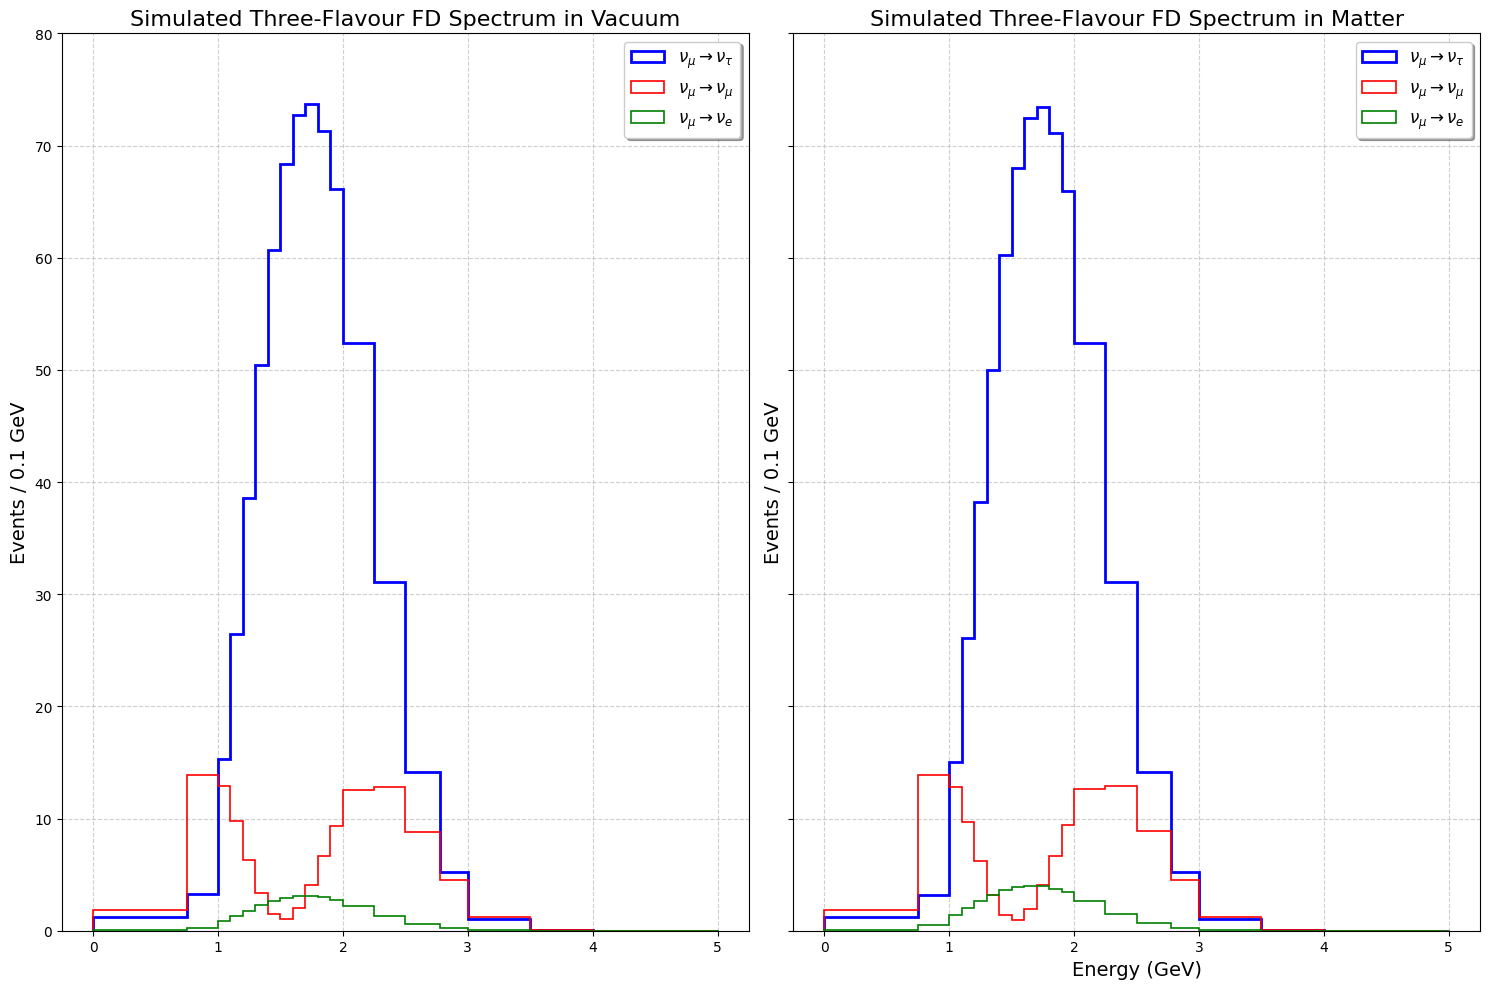

In [20]:
plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts_mt, histtype='step', label=r'$\nu_\mu \to \nu_\tau$', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_mm, histtype='step', label=r'$\nu_\mu\to\nu_\mu$', linewidth=1.2, color='red')
plt.hist(bin_edges[:-1], bin_edges, weights=counts2, histtype='step', label=r'$\nu_\mu\to\nu_e$', linewidth=1.2, color='green')

#plt.errorbar(bin_centers, counts2, yerr=error2, label='FD Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
#plt.errorbar(bin_centers, counts4, yerr=error4, label='FD Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour FD Spectrum In Vacuum'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts_mt2, histtype='step', label=r'$\nu_\mu \to \nu_\tau$', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_mm2, histtype='step', label=r'$\nu_\mu\to\nu_\mu$', linewidth=1.2, color='red')
plt.hist(bin_edges[:-1], bin_edges, weights=counts4, histtype='step', label=r'$\nu_\mu\to\nu_e$', linewidth=1.2, color='green')

#plt.errorbar(bin_centers, counts2, yerr=error2, label='FD Vacuum Data', fmt='o', capsize=5, ecolor='blue', elinewidth=1.5, markersize=1, markerfacecolor='black')
#plt.errorbar(bin_centers, counts4, yerr=error4, label='FD Matter Data', fmt='o', capsize=5, ecolor='red', elinewidth=1, markersize=1, markerfacecolor='black')
title = r'Simulated Three-Flavour FD Spectrum In Matter'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)

# Plot for Vacuum
axs[0].hist(bin_edges[:-1], bin_edges, weights=counts_mt, histtype='step', label=r'$\nu_\mu \to \nu_\tau$', linewidth=2, color='blue')
axs[0].hist(bin_edges[:-1], bin_edges, weights=counts_mm, histtype='step', label=r'$\nu_\mu\to\nu_\mu$', linewidth=1.2, color='red')
axs[0].hist(bin_edges[:-1], bin_edges, weights=counts2, histtype='step', label=r'$\nu_\mu\to\nu_e$', linewidth=1.2, color='green')
axs[0].set_title(r'Simulated Three-Flavour FD Spectrum in Vacuum', fontsize=16)
axs[0].set_ylabel('Events / 0.1 GeV', fontsize=14)
axs[0].legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].set_ylim(0, 80)  # add some padding to the top

# Plot for Matter
axs[1].hist(bin_edges[:-1], bin_edges, weights=counts_mt2, histtype='step', label=r'$\nu_\mu \to \nu_\tau$', linewidth=2, color='blue')
axs[1].hist(bin_edges[:-1], bin_edges, weights=counts_mm2, histtype='step', label=r'$\nu_\mu\to\nu_\mu$', linewidth=1.2, color='red')
axs[1].hist(bin_edges[:-1], bin_edges, weights=counts4, histtype='step', label=r'$\nu_\mu\to\nu_e$', linewidth=1.2, color='green')
axs[1].set_title(r'Simulated Three-Flavour FD Spectrum in Matter', fontsize=16)
axs[1].set_ylabel('Events / 0.1 GeV', fontsize=14)
axs[1].set_xlabel('Energy (GeV)', fontsize=14)
axs[1].legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].set_ylim(0, 80)  # same y-limit

plt.tight_layout()
plt.show()
